In [1]:
#Mouting drive for getting access to MyDrive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Importing libraries needed 

In [2]:
# Visualization Libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

#Preprocessing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# ML Libraries
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
from sklearn import metrics

#Dimensionality Reduction libraries
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [3]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

##Loading Preprocesd Data file to perform clustering.

In [18]:
crime = pd.read_pickle("drive/My Drive/Colab Notebooks/CMPE_255_Project/Chicago_Crime_Processed_Data.pkl")

In [19]:
crime.head()

,IUCR,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Month,Day_num,Time,day_of_week,primary_type_grouped,zone,Count_CrimeType_Column
0,0486,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,2015,41.815117,-87.670000,9,5,13,Saturday,NON-CRIMINAL_ASSAULT,South,1640154.0
1,0870,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,2015,41.895080,-87.765400,9,4,11,Friday,THEFT,North,2327482.0
3,2023,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,2015,41.937406,-87.716650,9,5,12,Saturday,NARCOTIC_OFFENSE,West,661033.0
4,0560,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,2015,41.881903,-87.755121,9,5,13,Saturday,NON-CRIMINAL_ASSAULT,North,1640154.0
5,0610,FORCIBLE ENTRY,RESIDENCE,False,False,614,6.0,21.0,71.0,05,2015,41.744379,-87.658431,9,5,10,Saturday,THEFT,South,2327482.0


In [20]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6626783 entries, 0 to 7311029
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   IUCR                    object 
 1   Description             object 
 2   Location Description    object 
 3   Arrest                  bool   
 4   Domestic                bool   
 5   Beat                    int64  
 6   District                float64
 7   Ward                    float64
 8   Community Area          float64
 9   FBI Code                object 
 10  Year                    int64  
 11  Latitude                float64
 12  Longitude               float64
 13  Month                   int64  
 14  Day_num                 int64  
 15  Time                    int64  
 16  day_of_week             object 
 17  primary_type_grouped    object 
 18  zone                    object 
 19  Count_CrimeType_Column  float64
dtypes: bool(2), float64(6), int64(5), object(7)
memory usage: 973.2+ MB


In [7]:
##Removing nan values if any

In [21]:
crime.isnull().sum().sum()

5348

In [22]:
crime.apply(lambda x: sum(x.isnull()),axis=0)

IUCR                         0
Description                  0
Location Description         0
Arrest                       0
Domestic                     0
Beat                         0
District                     0
Ward                         0
Community Area               0
FBI Code                     0
Year                         0
Latitude                     0
Longitude                    0
Month                        0
Day_num                      0
Time                         0
day_of_week                  0
primary_type_grouped      2674
zone                         0
Count_CrimeType_Column    2674
dtype: int64

In [23]:
## Number of unique values of crime type which will be number of clusters

In [24]:
crime['primary_type_grouped'].unique()

array(['NON-CRIMINAL_ASSAULT', 'THEFT', 'NARCOTIC_OFFENSE',
       'OTHER_OFFENSE', 'CRIMINAL_OFFENSE', 'WEAPONS_OFFENSE',
       'SEXUAL_OFFENSE', 'HUMAN_TRAFFICKING_OFFENSE', nan], dtype=object)

In [25]:
cime= crime.dropna(inplace=True)
crime = crime.reset_index(drop=True)

In [26]:
crime['primary_type_grouped'].unique()

array(['NON-CRIMINAL_ASSAULT', 'THEFT', 'NARCOTIC_OFFENSE',
       'OTHER_OFFENSE', 'CRIMINAL_OFFENSE', 'WEAPONS_OFFENSE',
       'SEXUAL_OFFENSE', 'HUMAN_TRAFFICKING_OFFENSE'], dtype=object)

In [27]:
# Remove irrelevant/not meaningful attributes
crime = crime.drop(['Count_CrimeType_Column'], axis=1)

In [28]:
crime.shape

(6624109, 19)

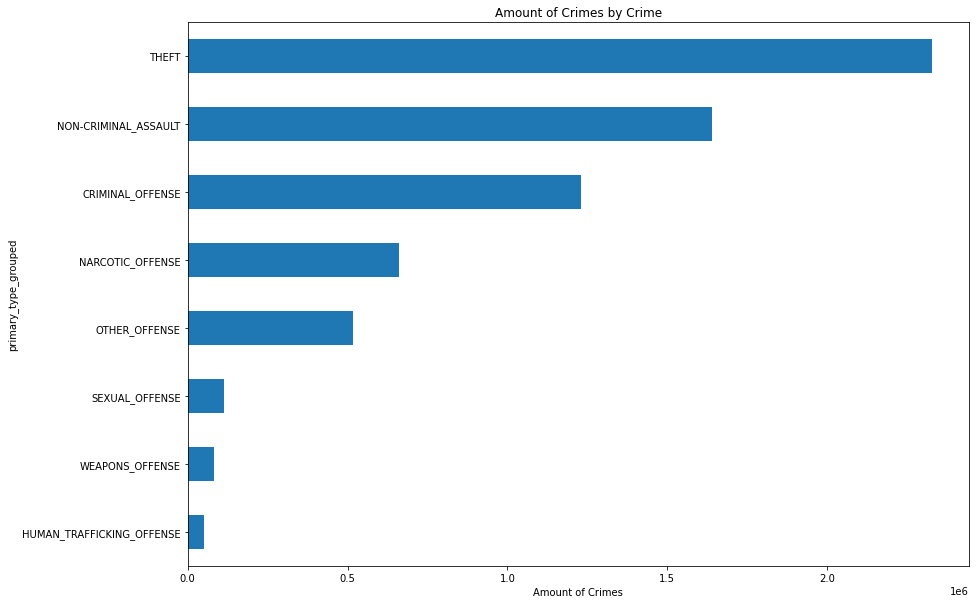

In [30]:
# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Crime')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

crime.groupby([crime['primary_type_grouped']]).size().sort_values(ascending=True).plot(kind='barh')
plt.show()

In [31]:
##Processing data further 

In [32]:
# Convert Categorical Attributes to Numerical
for col_name in crime.columns:
    if(crime[col_name].dtype == 'object'):
        crime[col_name]= crime[col_name].astype('category')
        crime[col_name] = crime[col_name].cat.codes

In [33]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6624109 entries, 0 to 6624108
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   IUCR                  int16  
 1   Description           int16  
 2   Location Description  int16  
 3   Arrest                bool   
 4   Domestic              bool   
 5   Beat                  int64  
 6   District              float64
 7   Ward                  float64
 8   Community Area        float64
 9   FBI Code              int8   
 10  Year                  int64  
 11  Latitude              float64
 12  Longitude             float64
 13  Month                 int64  
 14  Day_num               int64  
 15  Time                  int64  
 16  day_of_week           int8   
 17  primary_type_grouped  int8   
 18  zone                  int8   
dtypes: bool(2), float64(5), int16(3), int64(5), int8(4)
memory usage: 581.2 MB


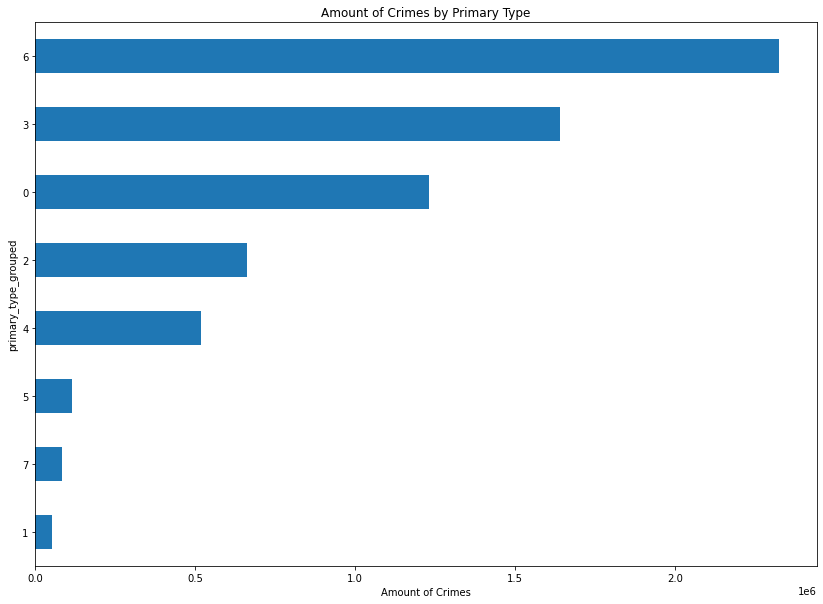

In [34]:
# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

crime.groupby([crime['primary_type_grouped']]).size().sort_values(ascending=True).plot(kind='barh')
plt.show()

##To check a correlation between various features and to see realtion of all features to target feature which is "primary_type_grouped" i.e. crime type.

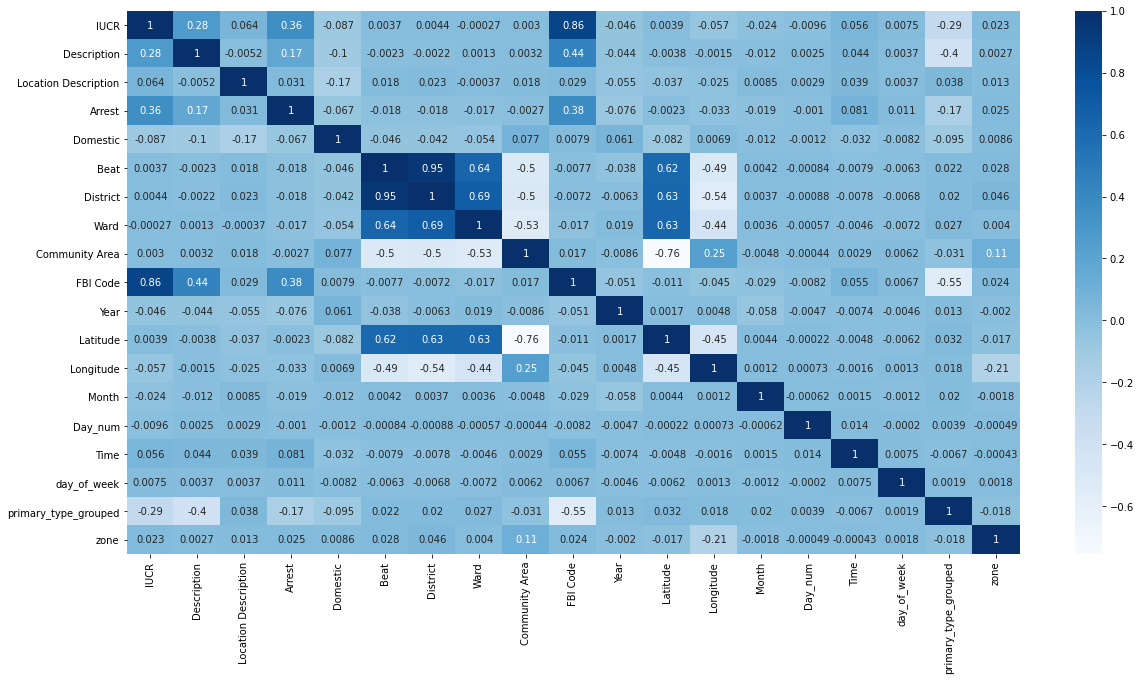

In [35]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_fs = crime.drop(['primary_type_grouped'], axis=1)
Y_fs = crime['primary_type_grouped']

#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = crime.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [36]:
#Correlation with output variable
cor_target = abs(cor['primary_type_grouped'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.03]
relevant_features

IUCR                    0.292668
Description             0.398370
Location Description    0.038127
Arrest                  0.166601
Domestic                0.095439
Community Area          0.031119
FBI Code                0.548101
Latitude                0.031977
primary_type_grouped    1.000000
Name: primary_type_grouped, dtype: float64

##Creating a dataframe for clustering with attributes which are highly related (threshold is 0.03 and higher) to target variable.

In [37]:
#new = old.filter(['A','B','D'], axis=1)
final_df= crime.filter(['IUCR','Description','Location Description','Arrest','Domestic','Community Area','FBI Code','Latitude','primary_type_grouped'],axis=1)

In [38]:
final_df.head()

,IUCR,Description,Location Description,Arrest,Domestic,Community Area,FBI Code,Latitude,primary_type_grouped
0,52,194,158,False,True,61.0,10,41.815117,3
1,95,348,68,False,False,25.0,7,41.895080,6
2,273,364,181,True,False,21.0,20,41.937406,2
3,75,428,17,False,True,25.0,9,41.881903,3
4,81,220,158,False,False,71.0,6,41.744379,6


In [22]:
#from sklearn.preprocessing import StandardScaler

##Normalization of data using min_max normalization.

In [39]:
from sklearn.preprocessing import MinMaxScaler

In [40]:
scaled_features = final_df.drop(['primary_type_grouped'],axis=1)

In [41]:
scaler = MinMaxScaler() 
scaler.fit(scaled_features)
scaled_features = scaler.transform(scaled_features)

In [42]:
scaled_features[0]

array([0.1319797 , 0.37236084, 0.74178404, 0.        , 1.        ,
       0.79220779, 0.4       , 0.96158019])

##Using Dimensionality Reduction Technique for dealing with higher dimensions.

In [43]:
pca = PCA(3)
pca.fit(scaled_features)
  
pca_data = pd.DataFrame(pca.transform(scaled_features))
  
print(pca_data.head())

          0         1         2
0 -0.454995  0.772719 -0.018267
1 -0.294382 -0.099917 -0.074687
2  0.896797 -0.106702  0.040118
3 -0.369000  0.876822 -0.324189
4 -0.363009 -0.133849  0.104402


In [44]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.34657516 0.18347193 0.15122639]


##Applying k-means clustering with k=8 as we know there are 8 unique values of target variable which is crime type.

In [45]:
#kmeans clustering using 3 features
from sklearn.cluster import KMeans
k_means=KMeans(n_clusters=8,random_state=42)
k_means.fit(pca_data[[0,1,2]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

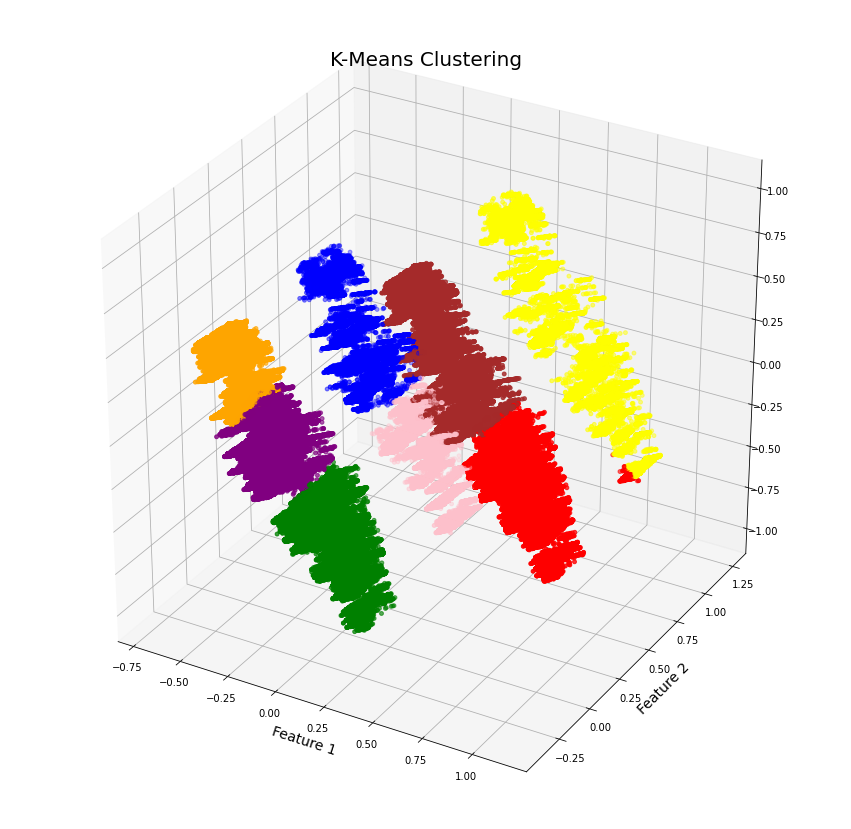

In [46]:
pca_data['KMeans_labels']=k_means.labels_

# Plotting resulting clusters
colors=['purple','red','blue','green','yellow','brown','pink','orange']

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection = '3d')

#plt.figure(figsize=(10,10))
ax.scatter(pca_data[0],pca_data[1],pca_data[2],c=pca_data['KMeans_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('K-Means Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
#plt.zlabel('Feature 3',fontsize=14)
plt.show()

##----------------------------------------------------------------------------------------------------------------------------------------------------------------##

##Experimental Code

##Running DBSCAN clustering algo for this large 20 years of crime data needs large computing resorces and as a result of continuous crashing of systm, decided to take data only for recent 5 years to perform DBSCAN clustering.But DBSCAN keeps crashing even for only 2021 year data. So further decided not to proceed this further.

In [47]:
#crimes_2021_year=crime[(crime['Year']>=2020) & (crime['Year']<=2020)]
crimes_2021_year=crime[(crime['Year']==2021)]

In [48]:
crimes_2021_year['Year'].unique()

array([2021])

In [49]:
crimes_2021_year.shape

(49450, 19)

In [50]:
crimes_2021_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49450 entries, 6278960 to 6624108
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   IUCR                  49450 non-null  int16  
 1   Description           49450 non-null  int16  
 2   Location Description  49450 non-null  int16  
 3   Arrest                49450 non-null  bool   
 4   Domestic              49450 non-null  bool   
 5   Beat                  49450 non-null  int64  
 6   District              49450 non-null  float64
 7   Ward                  49450 non-null  float64
 8   Community Area        49450 non-null  float64
 9   FBI Code              49450 non-null  int8   
 10  Year                  49450 non-null  int64  
 11  Latitude              49450 non-null  float64
 12  Longitude             49450 non-null  float64
 13  Month                 49450 non-null  int64  
 14  Day_num               49450 non-null  int64  
 15  Time       

In [51]:
crimes_2021_year.isnull().sum().sum()

0

In [52]:
final_df_DB = crimes_2021_year.filter(['IUCR','Description','Location Description','Arrest','Domestic','Community Area','FBI Code','Latitude','primary_type_grouped'],axis=1)

In [53]:
final_df_DB.head()

,IUCR,Description,Location Description,Arrest,Domestic,Community Area,FBI Code,Latitude,primary_type_grouped
6278960,52,194,17,False,True,68.0,10,41.766435,3
6296167,86,1,158,False,False,44.0,7,41.748474,6
6296254,52,194,17,False,True,25.0,10,41.882224,3
6300205,272,374,186,True,False,67.0,20,41.790069,2
6300210,0,217,186,False,False,43.0,0,41.771062,0


In [54]:
scaled_features_DB= final_df_DB.drop(['primary_type_grouped'],axis=1)

In [55]:
scaler.fit(scaled_features_DB)
scaled_features_DB = scaler.transform(scaled_features_DB)

In [56]:
scaled_features_DB[0]

array([0.1319797 , 0.37475728, 0.08018868, 0.        , 1.        ,
       0.88157895, 0.4       , 0.32234606])

In [57]:
pca.fit(scaled_features_DB)
  
pca_data_DB = pd.DataFrame(pca.transform(scaled_features_DB))
  
print(pca_data_DB.head())

          0         1         2
0  0.980900  0.105866 -0.138834
1 -0.040832 -0.469209 -0.393729
2  0.886293 -0.029014  0.397567
3 -0.539097  0.871863 -0.362387
4 -0.121300 -0.456453 -0.389188


In [58]:
print('Explained variation per principal component for DB: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component for DB: [0.26692355 0.20924332 0.16791608]


In [ ]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN()
dbscan.fit(pca_data_DB[[0,1,2]])

##DBSCAN keeps crashing as large amount of data is processed.It was crashing even for only 2021 year data.